# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

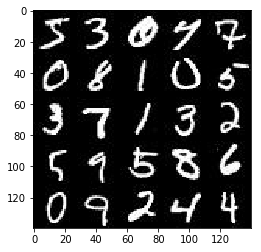

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

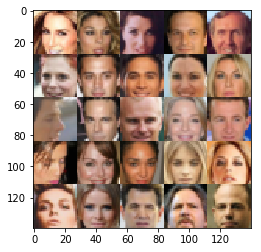

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/filatau/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 256

        # Second layer
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now

        #  Third Layer
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now

        # This is the 4th, output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28xout_channel_dim now        
        
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build model    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # Train model
                steps += 1
                batch_images *= 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0023... Generator Loss: 27.7955
Epoch 1/2... Discriminator Loss: 2.8265... Generator Loss: 14.9950
Epoch 1/2... Discriminator Loss: 0.0339... Generator Loss: 5.7104
Epoch 1/2... Discriminator Loss: 0.8793... Generator Loss: 1.8533
Epoch 1/2... Discriminator Loss: 0.0660... Generator Loss: 12.2455
Epoch 1/2... Discriminator Loss: 1.5179... Generator Loss: 10.7720
Epoch 1/2... Discriminator Loss: 1.5873... Generator Loss: 0.3036
Epoch 1/2... Discriminator Loss: 1.0018... Generator Loss: 1.5725
Epoch 1/2... Discriminator Loss: 0.1774... Generator Loss: 2.7743
Epoch 1/2... Discriminator Loss: 1.2934... Generator Loss: 5.2471


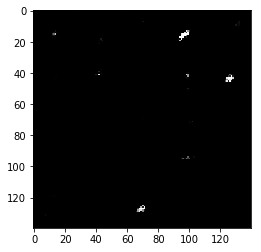

Epoch 1/2... Discriminator Loss: 0.8841... Generator Loss: 3.1186
Epoch 1/2... Discriminator Loss: 1.4249... Generator Loss: 0.5884
Epoch 1/2... Discriminator Loss: 0.4326... Generator Loss: 2.2517
Epoch 1/2... Discriminator Loss: 0.5540... Generator Loss: 1.4409
Epoch 1/2... Discriminator Loss: 0.6445... Generator Loss: 2.3969
Epoch 1/2... Discriminator Loss: 2.0432... Generator Loss: 0.2724
Epoch 1/2... Discriminator Loss: 1.0294... Generator Loss: 2.2810
Epoch 1/2... Discriminator Loss: 1.1274... Generator Loss: 3.3960
Epoch 1/2... Discriminator Loss: 1.0441... Generator Loss: 0.7054
Epoch 1/2... Discriminator Loss: 0.6674... Generator Loss: 1.6974


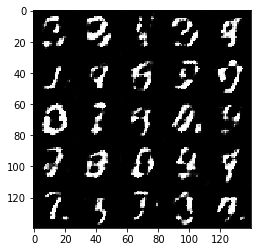

Epoch 1/2... Discriminator Loss: 1.2950... Generator Loss: 4.3067
Epoch 1/2... Discriminator Loss: 0.9523... Generator Loss: 1.4891
Epoch 1/2... Discriminator Loss: 1.9464... Generator Loss: 0.2502
Epoch 1/2... Discriminator Loss: 1.0123... Generator Loss: 0.7633
Epoch 1/2... Discriminator Loss: 0.3647... Generator Loss: 1.5887
Epoch 1/2... Discriminator Loss: 0.3474... Generator Loss: 1.7696
Epoch 1/2... Discriminator Loss: 0.6865... Generator Loss: 1.0759
Epoch 1/2... Discriminator Loss: 2.0464... Generator Loss: 2.4894
Epoch 1/2... Discriminator Loss: 1.5214... Generator Loss: 0.4763
Epoch 1/2... Discriminator Loss: 1.0352... Generator Loss: 0.8033


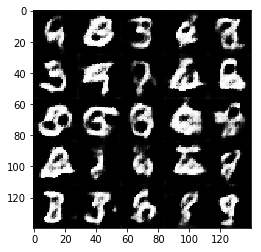

Epoch 1/2... Discriminator Loss: 1.2330... Generator Loss: 0.6317
Epoch 1/2... Discriminator Loss: 1.1491... Generator Loss: 0.7197
Epoch 1/2... Discriminator Loss: 1.2486... Generator Loss: 2.3143
Epoch 1/2... Discriminator Loss: 1.6817... Generator Loss: 0.2956
Epoch 1/2... Discriminator Loss: 0.8433... Generator Loss: 1.1799
Epoch 1/2... Discriminator Loss: 0.8839... Generator Loss: 1.8472
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 0.8726
Epoch 1/2... Discriminator Loss: 1.0522... Generator Loss: 0.6561
Epoch 1/2... Discriminator Loss: 1.0374... Generator Loss: 0.8135
Epoch 1/2... Discriminator Loss: 1.2506... Generator Loss: 0.5877


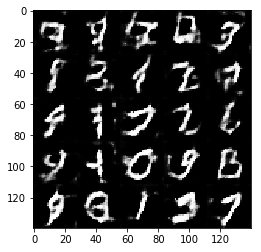

Epoch 1/2... Discriminator Loss: 1.0519... Generator Loss: 0.7010
Epoch 1/2... Discriminator Loss: 1.1059... Generator Loss: 0.7258
Epoch 1/2... Discriminator Loss: 1.0443... Generator Loss: 0.9718
Epoch 1/2... Discriminator Loss: 0.8903... Generator Loss: 0.9064
Epoch 1/2... Discriminator Loss: 0.9680... Generator Loss: 1.0516
Epoch 1/2... Discriminator Loss: 1.0242... Generator Loss: 0.9010
Epoch 1/2... Discriminator Loss: 1.2442... Generator Loss: 0.4987
Epoch 1/2... Discriminator Loss: 1.0847... Generator Loss: 0.7240
Epoch 1/2... Discriminator Loss: 0.9563... Generator Loss: 1.4367
Epoch 1/2... Discriminator Loss: 0.9674... Generator Loss: 0.7618


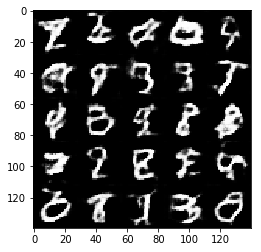

Epoch 1/2... Discriminator Loss: 1.0803... Generator Loss: 1.2110
Epoch 1/2... Discriminator Loss: 1.1085... Generator Loss: 0.5681
Epoch 1/2... Discriminator Loss: 1.1775... Generator Loss: 1.5324
Epoch 1/2... Discriminator Loss: 1.0147... Generator Loss: 1.1843
Epoch 1/2... Discriminator Loss: 0.9169... Generator Loss: 1.0494
Epoch 1/2... Discriminator Loss: 1.1987... Generator Loss: 1.4891
Epoch 1/2... Discriminator Loss: 1.1188... Generator Loss: 0.7999
Epoch 1/2... Discriminator Loss: 0.8883... Generator Loss: 1.1272
Epoch 1/2... Discriminator Loss: 1.1669... Generator Loss: 0.5929
Epoch 1/2... Discriminator Loss: 0.8537... Generator Loss: 1.6091


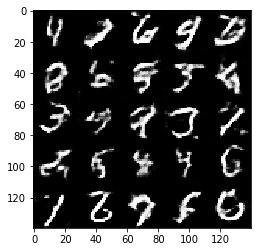

Epoch 1/2... Discriminator Loss: 1.0313... Generator Loss: 1.4080
Epoch 1/2... Discriminator Loss: 1.0556... Generator Loss: 0.8946
Epoch 1/2... Discriminator Loss: 1.4132... Generator Loss: 0.4291
Epoch 1/2... Discriminator Loss: 1.0063... Generator Loss: 0.7213
Epoch 1/2... Discriminator Loss: 1.0788... Generator Loss: 0.9161
Epoch 1/2... Discriminator Loss: 1.1025... Generator Loss: 0.6717
Epoch 1/2... Discriminator Loss: 0.9142... Generator Loss: 1.2019
Epoch 1/2... Discriminator Loss: 1.0718... Generator Loss: 0.7396
Epoch 1/2... Discriminator Loss: 1.1303... Generator Loss: 1.3943
Epoch 1/2... Discriminator Loss: 1.2123... Generator Loss: 1.6826


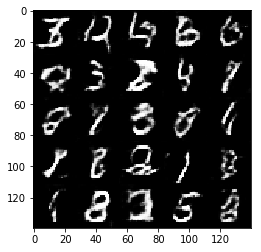

Epoch 1/2... Discriminator Loss: 1.0665... Generator Loss: 0.7104
Epoch 1/2... Discriminator Loss: 1.5398... Generator Loss: 0.3389
Epoch 1/2... Discriminator Loss: 0.8798... Generator Loss: 1.0002
Epoch 1/2... Discriminator Loss: 1.2044... Generator Loss: 2.0099
Epoch 1/2... Discriminator Loss: 0.9692... Generator Loss: 1.4222
Epoch 1/2... Discriminator Loss: 0.9355... Generator Loss: 0.8204
Epoch 1/2... Discriminator Loss: 0.8255... Generator Loss: 1.0497
Epoch 1/2... Discriminator Loss: 1.3487... Generator Loss: 0.4630
Epoch 1/2... Discriminator Loss: 1.4282... Generator Loss: 1.5445
Epoch 1/2... Discriminator Loss: 1.1151... Generator Loss: 0.7467


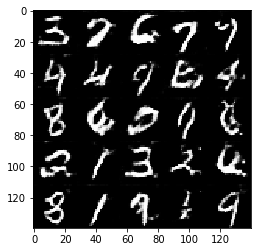

Epoch 1/2... Discriminator Loss: 0.7771... Generator Loss: 1.0678
Epoch 1/2... Discriminator Loss: 0.8302... Generator Loss: 0.9901
Epoch 1/2... Discriminator Loss: 1.5222... Generator Loss: 0.3940
Epoch 1/2... Discriminator Loss: 0.7012... Generator Loss: 1.8801
Epoch 1/2... Discriminator Loss: 0.7862... Generator Loss: 1.0882
Epoch 1/2... Discriminator Loss: 1.5308... Generator Loss: 0.5269
Epoch 1/2... Discriminator Loss: 1.1447... Generator Loss: 1.1451
Epoch 1/2... Discriminator Loss: 0.9315... Generator Loss: 0.8389
Epoch 1/2... Discriminator Loss: 0.8791... Generator Loss: 1.2166
Epoch 1/2... Discriminator Loss: 1.0546... Generator Loss: 0.7210


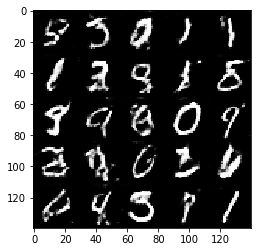

Epoch 1/2... Discriminator Loss: 1.2048... Generator Loss: 0.5847
Epoch 1/2... Discriminator Loss: 1.8886... Generator Loss: 2.8476
Epoch 1/2... Discriminator Loss: 1.1724... Generator Loss: 0.8534
Epoch 2/2... Discriminator Loss: 1.4263... Generator Loss: 0.3963
Epoch 2/2... Discriminator Loss: 0.9074... Generator Loss: 1.3648
Epoch 2/2... Discriminator Loss: 0.8773... Generator Loss: 0.8230
Epoch 2/2... Discriminator Loss: 1.4379... Generator Loss: 0.4015
Epoch 2/2... Discriminator Loss: 1.1428... Generator Loss: 0.7471
Epoch 2/2... Discriminator Loss: 1.2550... Generator Loss: 1.1448
Epoch 2/2... Discriminator Loss: 1.0845... Generator Loss: 1.6018


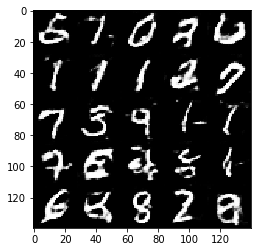

Epoch 2/2... Discriminator Loss: 1.1294... Generator Loss: 0.6560
Epoch 2/2... Discriminator Loss: 0.8438... Generator Loss: 1.1182
Epoch 2/2... Discriminator Loss: 0.6689... Generator Loss: 1.2455
Epoch 2/2... Discriminator Loss: 1.2370... Generator Loss: 1.3793
Epoch 2/2... Discriminator Loss: 0.8751... Generator Loss: 1.2265
Epoch 2/2... Discriminator Loss: 0.9402... Generator Loss: 1.0581
Epoch 2/2... Discriminator Loss: 0.7492... Generator Loss: 1.3519
Epoch 2/2... Discriminator Loss: 1.1395... Generator Loss: 0.5410
Epoch 2/2... Discriminator Loss: 0.7745... Generator Loss: 1.1145
Epoch 2/2... Discriminator Loss: 1.2575... Generator Loss: 0.5392


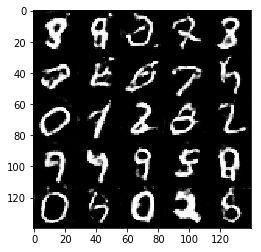

Epoch 2/2... Discriminator Loss: 0.8532... Generator Loss: 1.2497
Epoch 2/2... Discriminator Loss: 0.8216... Generator Loss: 0.9322
Epoch 2/2... Discriminator Loss: 0.9184... Generator Loss: 0.7084
Epoch 2/2... Discriminator Loss: 1.2853... Generator Loss: 0.4764
Epoch 2/2... Discriminator Loss: 0.9602... Generator Loss: 0.7160
Epoch 2/2... Discriminator Loss: 1.1394... Generator Loss: 1.8576
Epoch 2/2... Discriminator Loss: 0.8920... Generator Loss: 0.9698
Epoch 2/2... Discriminator Loss: 1.9265... Generator Loss: 0.2322
Epoch 2/2... Discriminator Loss: 1.2487... Generator Loss: 1.0307
Epoch 2/2... Discriminator Loss: 1.0783... Generator Loss: 1.0258


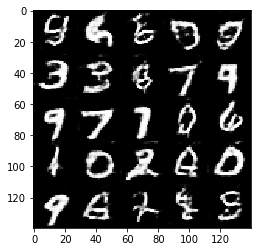

Epoch 2/2... Discriminator Loss: 0.7443... Generator Loss: 1.0042
Epoch 2/2... Discriminator Loss: 1.0076... Generator Loss: 0.7622
Epoch 2/2... Discriminator Loss: 1.4412... Generator Loss: 0.4488
Epoch 2/2... Discriminator Loss: 1.1250... Generator Loss: 0.6452
Epoch 2/2... Discriminator Loss: 1.0294... Generator Loss: 1.6316
Epoch 2/2... Discriminator Loss: 1.0110... Generator Loss: 0.7702
Epoch 2/2... Discriminator Loss: 1.2317... Generator Loss: 0.4964
Epoch 2/2... Discriminator Loss: 1.3387... Generator Loss: 0.4375
Epoch 2/2... Discriminator Loss: 0.6686... Generator Loss: 1.2176
Epoch 2/2... Discriminator Loss: 0.8538... Generator Loss: 1.0571


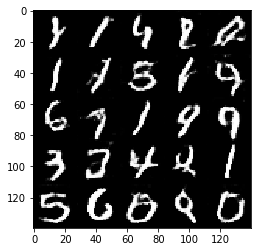

Epoch 2/2... Discriminator Loss: 1.0005... Generator Loss: 0.8795
Epoch 2/2... Discriminator Loss: 1.4413... Generator Loss: 0.4765
Epoch 2/2... Discriminator Loss: 1.8217... Generator Loss: 3.6039
Epoch 2/2... Discriminator Loss: 1.0817... Generator Loss: 0.8982
Epoch 2/2... Discriminator Loss: 1.4454... Generator Loss: 0.4249
Epoch 2/2... Discriminator Loss: 0.8202... Generator Loss: 1.0765
Epoch 2/2... Discriminator Loss: 0.7844... Generator Loss: 1.2158
Epoch 2/2... Discriminator Loss: 1.1112... Generator Loss: 0.5656
Epoch 2/2... Discriminator Loss: 0.9872... Generator Loss: 0.8004
Epoch 2/2... Discriminator Loss: 1.7700... Generator Loss: 0.2696


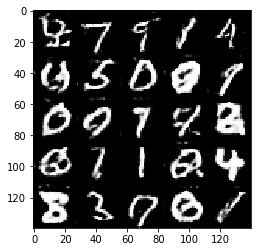

Epoch 2/2... Discriminator Loss: 0.9950... Generator Loss: 0.7165
Epoch 2/2... Discriminator Loss: 0.8400... Generator Loss: 1.0964
Epoch 2/2... Discriminator Loss: 0.9162... Generator Loss: 1.1514
Epoch 2/2... Discriminator Loss: 0.8653... Generator Loss: 0.8392
Epoch 2/2... Discriminator Loss: 1.7222... Generator Loss: 0.3282
Epoch 2/2... Discriminator Loss: 0.9258... Generator Loss: 0.8293
Epoch 2/2... Discriminator Loss: 1.8812... Generator Loss: 0.2413
Epoch 2/2... Discriminator Loss: 1.4487... Generator Loss: 0.4848
Epoch 2/2... Discriminator Loss: 0.6738... Generator Loss: 1.8180
Epoch 2/2... Discriminator Loss: 0.7302... Generator Loss: 1.1618


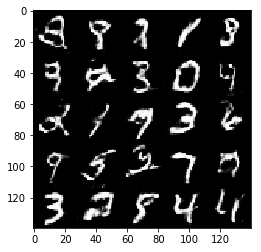

Epoch 2/2... Discriminator Loss: 0.9328... Generator Loss: 0.8606
Epoch 2/2... Discriminator Loss: 0.6696... Generator Loss: 1.0261
Epoch 2/2... Discriminator Loss: 0.4412... Generator Loss: 1.7740
Epoch 2/2... Discriminator Loss: 0.4387... Generator Loss: 1.6585
Epoch 2/2... Discriminator Loss: 0.8088... Generator Loss: 0.9929
Epoch 2/2... Discriminator Loss: 2.6787... Generator Loss: 4.8092
Epoch 2/2... Discriminator Loss: 1.2911... Generator Loss: 0.5307
Epoch 2/2... Discriminator Loss: 1.0613... Generator Loss: 0.6223
Epoch 2/2... Discriminator Loss: 1.2811... Generator Loss: 0.5367
Epoch 2/2... Discriminator Loss: 0.7166... Generator Loss: 1.4667


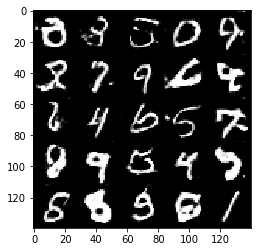

Epoch 2/2... Discriminator Loss: 1.1994... Generator Loss: 1.4449
Epoch 2/2... Discriminator Loss: 0.7230... Generator Loss: 0.9912
Epoch 2/2... Discriminator Loss: 1.6241... Generator Loss: 0.3681
Epoch 2/2... Discriminator Loss: 1.0399... Generator Loss: 0.6781
Epoch 2/2... Discriminator Loss: 0.6596... Generator Loss: 1.1730
Epoch 2/2... Discriminator Loss: 0.4234... Generator Loss: 2.8538
Epoch 2/2... Discriminator Loss: 0.6710... Generator Loss: 1.2222
Epoch 2/2... Discriminator Loss: 0.7676... Generator Loss: 2.7026
Epoch 2/2... Discriminator Loss: 1.1608... Generator Loss: 0.6034
Epoch 2/2... Discriminator Loss: 1.2852... Generator Loss: 0.4984


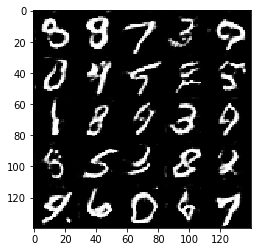

Epoch 2/2... Discriminator Loss: 0.8472... Generator Loss: 1.1913
Epoch 2/2... Discriminator Loss: 0.7732... Generator Loss: 1.9910
Epoch 2/2... Discriminator Loss: 0.7989... Generator Loss: 1.7678
Epoch 2/2... Discriminator Loss: 0.7581... Generator Loss: 1.0883
Epoch 2/2... Discriminator Loss: 0.4837... Generator Loss: 1.8710
Epoch 2/2... Discriminator Loss: 0.3848... Generator Loss: 1.8139
Epoch 2/2... Discriminator Loss: 0.7704... Generator Loss: 0.9646
Epoch 2/2... Discriminator Loss: 2.9493... Generator Loss: 0.1795
Epoch 2/2... Discriminator Loss: 0.7877... Generator Loss: 0.9027
Epoch 2/2... Discriminator Loss: 1.5854... Generator Loss: 0.4963


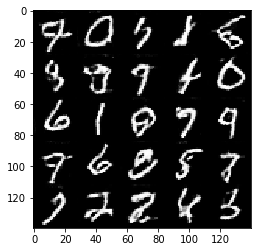

Epoch 2/2... Discriminator Loss: 0.9860... Generator Loss: 1.1418
Epoch 2/2... Discriminator Loss: 1.0928... Generator Loss: 0.7770
Epoch 2/2... Discriminator Loss: 0.9557... Generator Loss: 0.9015
Epoch 2/2... Discriminator Loss: 0.7481... Generator Loss: 1.5207
Epoch 2/2... Discriminator Loss: 1.4672... Generator Loss: 3.4440
Epoch 2/2... Discriminator Loss: 0.8426... Generator Loss: 1.0985
Epoch 2/2... Discriminator Loss: 0.5684... Generator Loss: 1.3498


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0030... Generator Loss: 23.8163
Epoch 1/1... Discriminator Loss: 0.0023... Generator Loss: 15.5255
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 2.7279
Epoch 1/1... Discriminator Loss: 0.3700... Generator Loss: 2.8988
Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 1.9767
Epoch 1/1... Discriminator Loss: 0.7775... Generator Loss: 3.2507
Epoch 1/1... Discriminator Loss: 0.2146... Generator Loss: 2.9021
Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 1.3461
Epoch 1/1... Discriminator Loss: 0.1538... Generator Loss: 3.1087
Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 5.7601


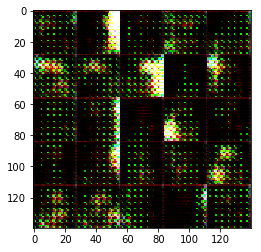

Epoch 1/1... Discriminator Loss: 0.1615... Generator Loss: 3.0093
Epoch 1/1... Discriminator Loss: 0.1042... Generator Loss: 3.1405
Epoch 1/1... Discriminator Loss: 0.1040... Generator Loss: 3.3211
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 4.2283
Epoch 1/1... Discriminator Loss: 0.2020... Generator Loss: 3.3818
Epoch 1/1... Discriminator Loss: 1.8846... Generator Loss: 0.3373
Epoch 1/1... Discriminator Loss: 0.3309... Generator Loss: 1.7858
Epoch 1/1... Discriminator Loss: 0.0854... Generator Loss: 3.3035
Epoch 1/1... Discriminator Loss: 2.4167... Generator Loss: 5.0898
Epoch 1/1... Discriminator Loss: 0.8733... Generator Loss: 1.6864


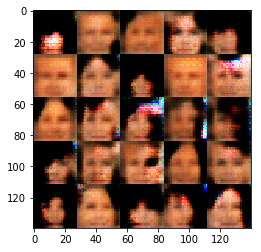

Epoch 1/1... Discriminator Loss: 0.8174... Generator Loss: 1.8892
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 3.3952
Epoch 1/1... Discriminator Loss: 1.9639... Generator Loss: 0.2318
Epoch 1/1... Discriminator Loss: 3.7167... Generator Loss: 0.0411
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 0.9318... Generator Loss: 1.4549
Epoch 1/1... Discriminator Loss: 1.6337... Generator Loss: 0.3381
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 2.0324
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 1.0677
Epoch 1/1... Discriminator Loss: 0.5771... Generator Loss: 1.3446


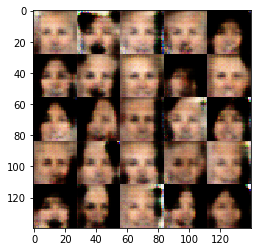

Epoch 1/1... Discriminator Loss: 0.8029... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 1.8483
Epoch 1/1... Discriminator Loss: 1.5549... Generator Loss: 0.4201
Epoch 1/1... Discriminator Loss: 1.6718... Generator Loss: 1.5107
Epoch 1/1... Discriminator Loss: 0.6835... Generator Loss: 1.0612
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 1.2842
Epoch 1/1... Discriminator Loss: 2.0520... Generator Loss: 2.7183
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 0.8640


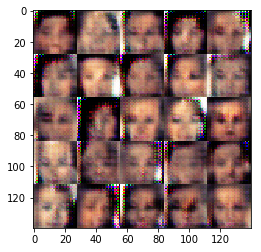

Epoch 1/1... Discriminator Loss: 0.7284... Generator Loss: 1.3420
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 1.8021
Epoch 1/1... Discriminator Loss: 2.6045... Generator Loss: 0.1008
Epoch 1/1... Discriminator Loss: 0.9180... Generator Loss: 0.9523
Epoch 1/1... Discriminator Loss: 0.9251... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.7458... Generator Loss: 0.2801
Epoch 1/1... Discriminator Loss: 0.9469... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.5969


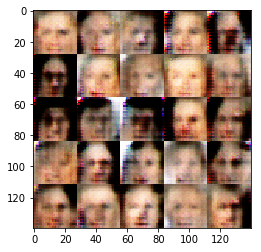

Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 2.2696
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 1.4201
Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 1.6222... Generator Loss: 2.1705
Epoch 1/1... Discriminator Loss: 1.6130... Generator Loss: 0.3146
Epoch 1/1... Discriminator Loss: 0.7243... Generator Loss: 0.8785
Epoch 1/1... Discriminator Loss: 1.8035... Generator Loss: 2.9025
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 0.9601


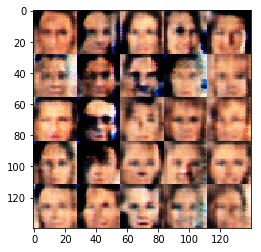

Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 1.5605... Generator Loss: 2.3260
Epoch 1/1... Discriminator Loss: 1.5601... Generator Loss: 0.3963
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.5457
Epoch 1/1... Discriminator Loss: 0.9964... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 2.4125... Generator Loss: 0.1274
Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 0.8525... Generator Loss: 0.7941


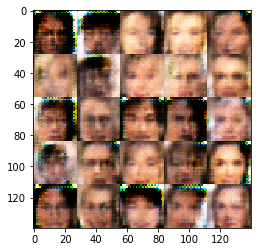

Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.5092
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.3647
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 1.3176
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.4699
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 1.3869
Epoch 1/1... Discriminator Loss: 0.8126... Generator Loss: 1.0749
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 0.9931
Epoch 1/1... Discriminator Loss: 2.0117... Generator Loss: 0.1822


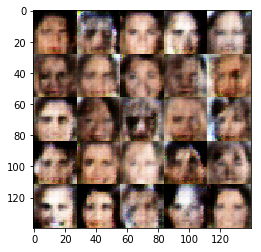

Epoch 1/1... Discriminator Loss: 2.5000... Generator Loss: 2.8229
Epoch 1/1... Discriminator Loss: 0.9045... Generator Loss: 0.9884
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.5708
Epoch 1/1... Discriminator Loss: 1.5558... Generator Loss: 1.3561
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.6109
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.3888
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.3180
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 1.2589
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.7451


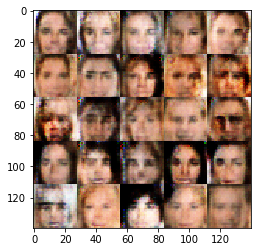

Epoch 1/1... Discriminator Loss: 0.4139... Generator Loss: 1.8782
Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 1.0225
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 0.5315
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.4696
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 1.1739
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.5691... Generator Loss: 0.3833
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.4417


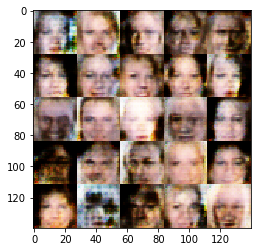

Epoch 1/1... Discriminator Loss: 2.1359... Generator Loss: 0.1685
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 1.4235
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.0337... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.7692... Generator Loss: 0.2562
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.5669


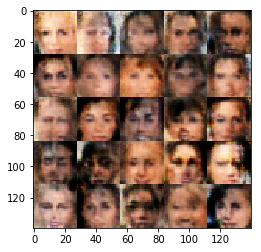

Epoch 1/1... Discriminator Loss: 1.6914... Generator Loss: 0.9751
Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 0.9879
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.5770
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.3255
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.5332
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 1.0374


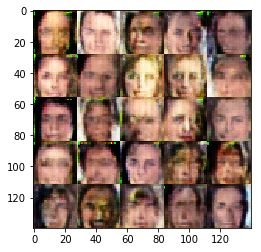

Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 0.3637... Generator Loss: 1.7107
Epoch 1/1... Discriminator Loss: 2.5712... Generator Loss: 2.8822
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 0.9064
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 1.2548
Epoch 1/1... Discriminator Loss: 2.3176... Generator Loss: 2.3711
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 1.2438
Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 1.1092


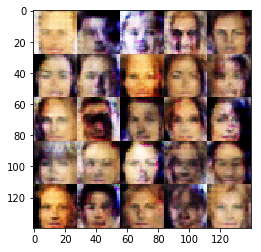

Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 0.5553
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.5424
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.5441
Epoch 1/1... Discriminator Loss: 1.5216... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.6207... Generator Loss: 0.7145


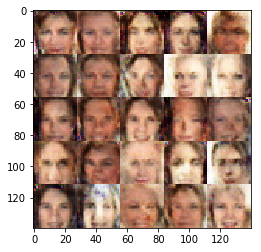

Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.5025
Epoch 1/1... Discriminator Loss: 1.5177... Generator Loss: 0.4392
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 1.1201
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.4697
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 0.8306


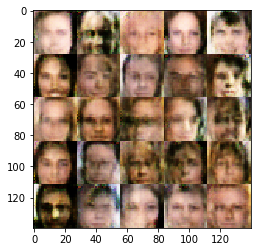

Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.3760
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 1.2067
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.3933
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 2.9623... Generator Loss: 3.5044
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.6541


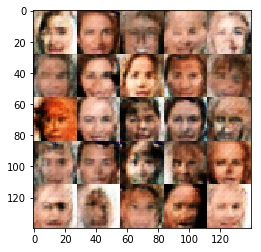

Epoch 1/1... Discriminator Loss: 1.9127... Generator Loss: 0.2110
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.2384
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 1.3159
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 0.9047
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 1.5527
Epoch 1/1... Discriminator Loss: 1.6793... Generator Loss: 0.3515
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.7323


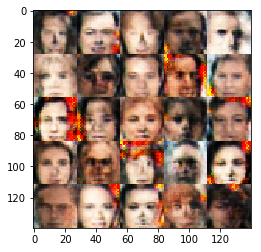

Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.6652... Generator Loss: 0.2824
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.9129
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.4305
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 1.7496
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.8712


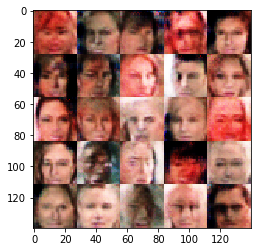

Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 1.0640
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 0.9992
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.3931
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 0.5904


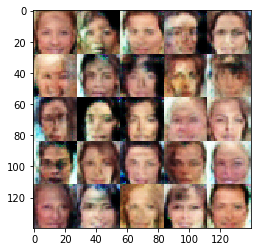

Epoch 1/1... Discriminator Loss: 1.6773... Generator Loss: 1.3529
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.9561
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.4950
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.3179
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 1.0256
Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 1.0858
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.6936


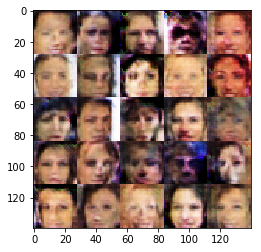

Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.4886
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 1.1033
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.7824


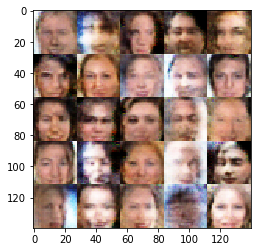

Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 1.0721
Epoch 1/1... Discriminator Loss: 1.5552... Generator Loss: 0.3346
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 1.0652
Epoch 1/1... Discriminator Loss: 1.6519... Generator Loss: 0.3288
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.4653
Epoch 1/1... Discriminator Loss: 1.5289... Generator Loss: 0.5232
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.5140


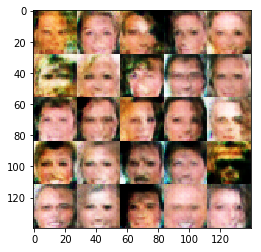

Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.5782... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.5627... Generator Loss: 0.4798
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.5480
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.5133
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.3988


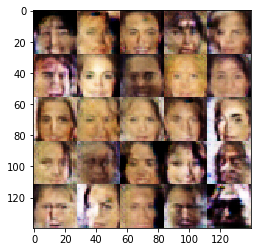

Epoch 1/1... Discriminator Loss: 1.9283... Generator Loss: 1.8727
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.5077
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.5076
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.5108
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.6584


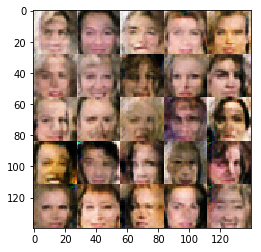

Epoch 1/1... Discriminator Loss: 1.5534... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 1.0914... Generator Loss: 0.9200
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.6396... Generator Loss: 0.3304
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.4369
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.4045
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 1.1650


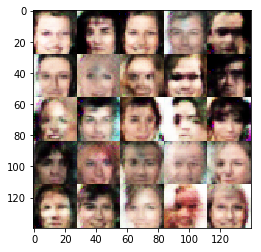

Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.4821
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.4375


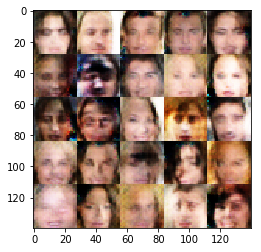

Epoch 1/1... Discriminator Loss: 1.6759... Generator Loss: 0.2667
Epoch 1/1... Discriminator Loss: 1.6479... Generator Loss: 0.5209
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.5357
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.7193


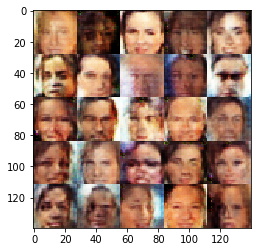

Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.6165... Generator Loss: 0.4242
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.5510
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.4837
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 1.5844... Generator Loss: 0.6214


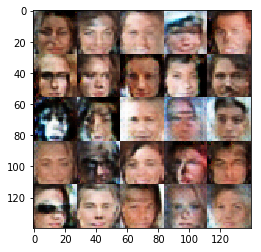

Epoch 1/1... Discriminator Loss: 1.6405... Generator Loss: 0.4333
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.4226
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.5666
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.6063


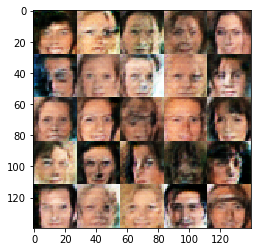

Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 1.1021
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.6393


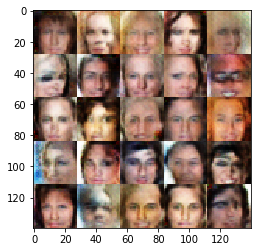

Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.4824
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.4823
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.5430


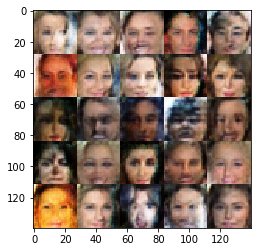

Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.4446
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.4602
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.5514
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.5665
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.5548


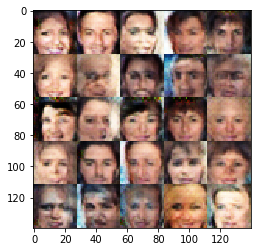

Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 1.1397
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.5468
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.4597
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.5112
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 1.0276


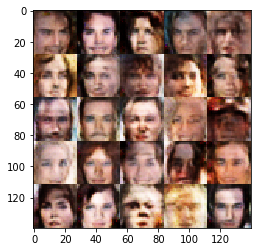

Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 1.5984... Generator Loss: 0.3846
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.5722
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.4128


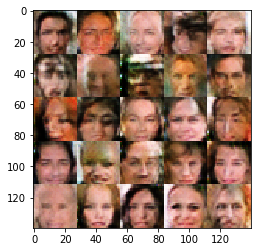

Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.5698
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.5548


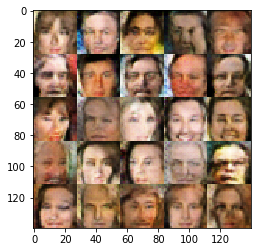

Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.5524
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.4636
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.6754


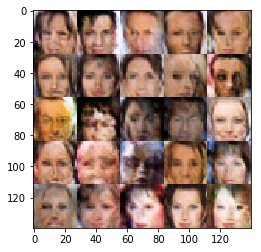

Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 0.5377
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.8062


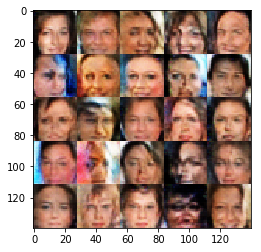

Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.4938
Epoch 1/1... Discriminator Loss: 1.5623... Generator Loss: 0.5603
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.9190
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.4840
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.6867


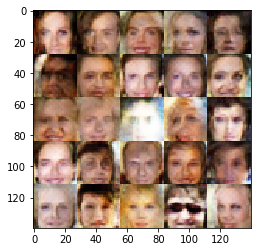

Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.8067


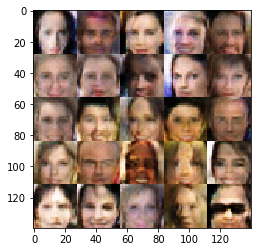

Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.4827
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.5809


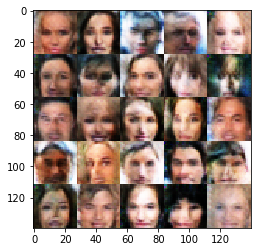

Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.4444
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.6626


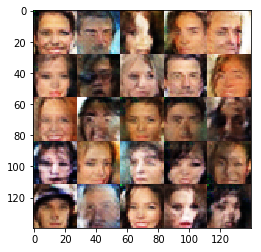

Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.4422
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.5798
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.7273


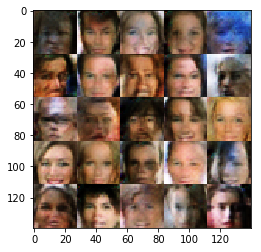

Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.5426
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.5857
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6467


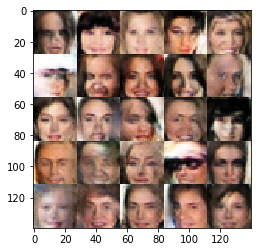

Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.5272... Generator Loss: 0.3849
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.5187
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.8192


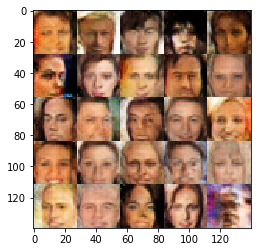

Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.6783


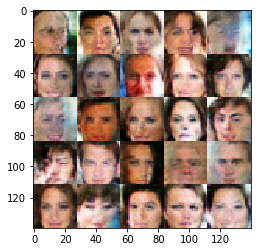

Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 1.0014
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.5437
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.5572
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 0.5655


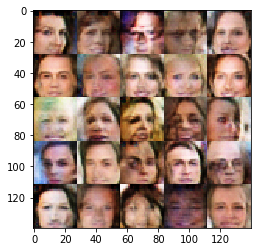

Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.5277
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.5285
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.4309
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.5005
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.5449


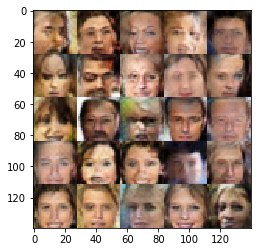

Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.5733... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.6894


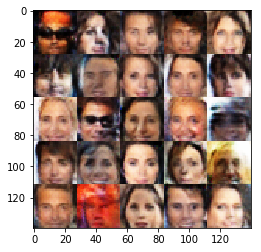

Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.5057
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.5064


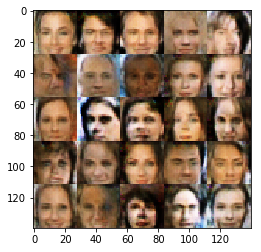

Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.5313
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.7206


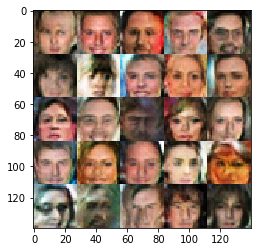

Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.5305
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.7987


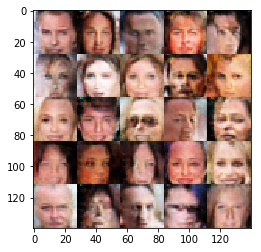

Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.8540


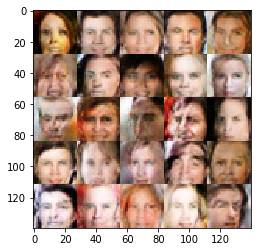

Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.4807
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.5226... Generator Loss: 0.4459
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.6962


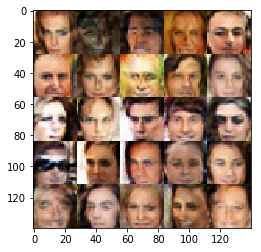

Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.6513


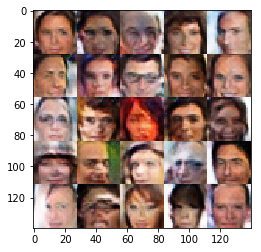

Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.5721
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.5755
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.6855


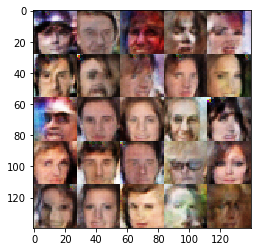

Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.5219
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.5515


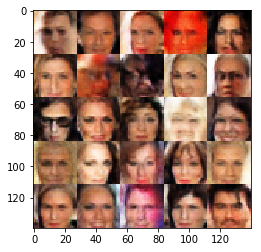

Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.5996... Generator Loss: 0.3812
Epoch 1/1... Discriminator Loss: 1.5177... Generator Loss: 0.5480
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.7143


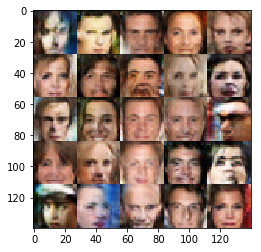

Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.6994


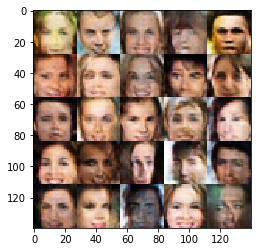

Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7413


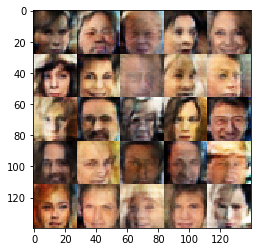

Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.5502
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.5185
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.6470


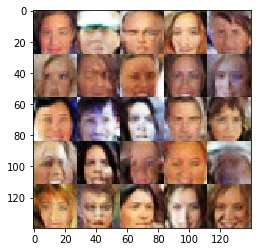

Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 1.0702
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.6870


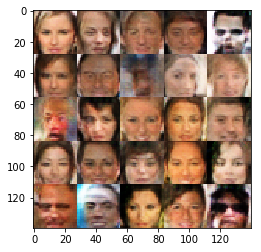

Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.5706
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.6812


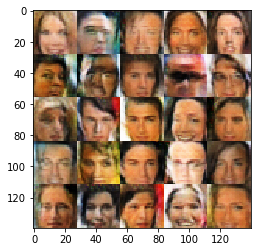

Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.5407
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.5471


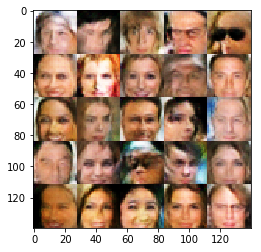

Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.6658


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.